<a href="https://colab.research.google.com/github/EgriSandor/Szovegbanyaszat/blob/main/Sz%C3%B6vegb%C3%A1ny%C3%A1szat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#modulok importálása
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as txt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import davies_bouldin_score


Az adatok a Kaggle publikus Dataset gyűjteményből származnak:
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

A könnyebb elérhetőséghez a saját GitHub fiókom erre a célra létrehozott nyilvános repositoryjából kerül beolvasásra.

In [5]:
#adatok beolvasása
train = pd.read_csv("https://raw.githubusercontent.com/EgriSandor/Szovegbanyaszat/main/Corona_NLP_train.csv.txt", usecols= ['OriginalTweet','Sentiment'], dtype='string', encoding='utf-8')
test = pd.read_csv("https://raw.githubusercontent.com/EgriSandor/Szovegbanyaszat/main/Corona_NLP_test.csv.txt", usecols= ['OriginalTweet','Sentiment'], dtype='string', encoding='utf-8')


A következő cellában a vélemény (sentiment) értékek frekvenciatáblázatát számítjuk majd rajzoluk ki, a tanító adathalmaz kék, a teszt pedig narancs színnel jelölve.

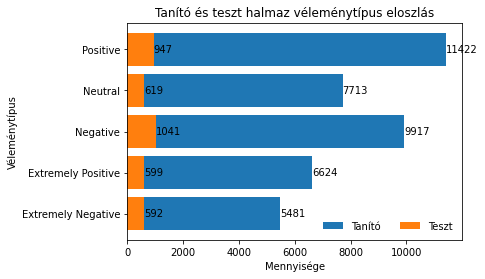

In [6]:
train_sentiment_freq = pd.crosstab(train.Sentiment, columns="mennyiseg")
test_sentiment_freq = pd.crosstab(test.Sentiment, columns="mennyiseg")

fig = plt.figure(1);
plt.title('Tanító és teszt halmaz véleménytípus eloszlás');
plt.xlabel('Mennyisége');
plt.ylabel('Véleménytípus');
p1 = plt.barh(train_sentiment_freq.index,train_sentiment_freq.mennyiseg, align='center', label='Tanító');
p2 = plt.barh(test_sentiment_freq.index,test_sentiment_freq.mennyiseg, align='center', label='Teszt');
plt.bar_label(p1, label_type='edge')
plt.bar_label(p2, label_type='edge')
plt.legend(frameon=False, loc='lower right', ncol=2)
plt.show(); 

A különböző véleménytípusok szerint szűrve előállítjuk a szóvektorokat, majd egy-egy grafikonon megjelenítjük. A leggyakoribb szavakat kiszűrjük, melyek a "https", "coronavirus", "covid" és "19", az előbbi a Twitter linkek miatt lesz a leggyakoribb,

Az eloszlásokból látható, hogy nagyjából hasonló szavak vannak, de a negatív típusoknál erős gyakoriságú a "panic" és "crisis" szavak, míg a pozitívaknál megjelenik a "sanitizer". 

A "toiletpaper" viszont a neutral típusú bejegyzéseknél kerül előtérbe.

A szóvektor minimális vágási értéke viszonylag magas (0.01), így a szótár 211 szóból áll

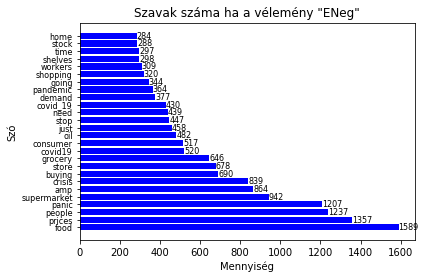

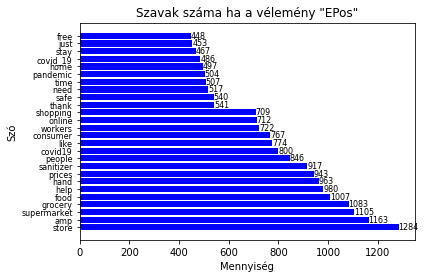

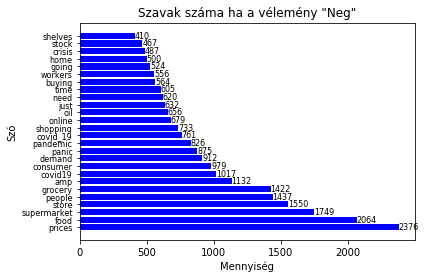

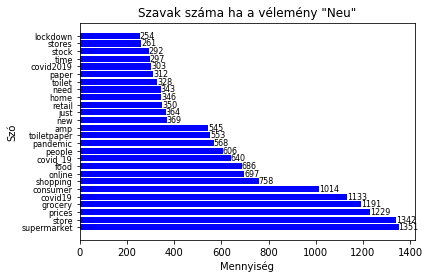

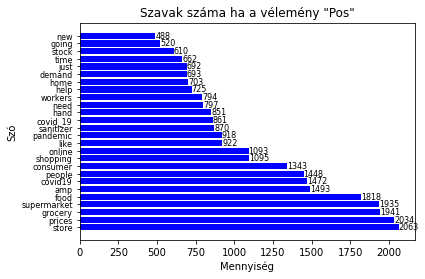

In [20]:
min_pr = 0.01;  
vectorizer = txt.CountVectorizer(stop_words='english',min_df=min_pr); 

for s in train_sentiment_freq.index :
    ts = train['Sentiment']==s
    tt = train[ts]
    DT_train = vectorizer.fit_transform(tt.OriginalTweet); 
    vocabulary_list = vectorizer.get_feature_names_out();
    vocabulary = np.asarray(vocabulary_list);
    keywords_freq = np.transpose(np.asarray(np.sum(DT_train,axis=0)))[:,0];
    
    voca_pd = pd.DataFrame({'word': vocabulary, 'count': keywords_freq})
    vpds = voca_pd.sort_values("count", axis = 0, ascending = False )

    fig = plt.figure(1);
    plt.title(f'Szavak száma ha a vélemény "{s}"');
    plt.xlabel('Mennyiség');
    plt.ylabel('Szó');
    p = plt.barh(vpds['word'][4:30],vpds['count'][4:30], align='center', color='blue');
    plt.tick_params(axis='y', labelsize=8)
    plt.bar_label(p, label_type='edge', fontsize=8)
    plt.show(); 

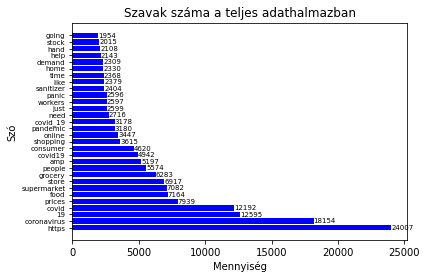

A szóvektor szótár hossza: 211


In [22]:
DT_train = vectorizer.fit_transform(train.OriginalTweet); 
vocabulary_list = vectorizer.get_feature_names_out();
vocabulary = np.asarray(vocabulary_list);
stopwords = vectorizer.stop_words_;
keywords_freq = np.transpose(np.asarray(np.sum(DT_train,axis=0)))[:,0];

voca_pd = pd.DataFrame({'word': vocabulary, 'count': keywords_freq})
vpds = voca_pd.sort_values("count", axis = 0, ascending = False )

fig = plt.figure(2);
plt.title('Szavak száma a teljes adathalmazban');
plt.xlabel('Mennyiség');
plt.ylabel('Szó');
p = plt.barh(vpds['word'][0:30],vpds['count'][0:30], align='center', color='blue');
plt.tick_params(axis='y', labelsize=7)
plt.bar_label(p, label_type='edge', fontsize=7)
plt.show(); 

print(f"A szóvektor szótár hossza: {len(vocabulary)}")

In [ ]:
#Az tanító és teszt adatok DataFrame-jeiben a Sentiment attribútum értékeit lecserélem rövidebb szavakra,
# hogy a konfúziós mátrix ábrákon a címkék ne lógjanak egymásra.
train['Sentiment'].replace({'Neutral' : 'Neu', 'Positive' : 'Pos', 
                            'Negative' : 'Neg', 'Extremely Negative' : 'ENeg',
                            'Extremely Positive' : 'EPos'}, inplace=True )
test['Sentiment'].replace({'Neutral' : 'Neu', 'Positive' : 'Pos', 
                            'Negative' : 'Neg', 'Extremely Negative' : 'ENeg',
                            'Extremely Positive' : 'EPos'}, inplace=True )

train_sentiment_freq = pd.crosstab(train.Sentiment, columns="mennyiseg")
test_sentiment_freq = pd.crosstab(test.Sentiment, columns="mennyiseg")

A tanító adathalmaz segítségével egy multinomiális naív Bayes osztályozót került betanításra, majd mind a tanító, mind a teszt halmazon történő predikció összehasolításra kerül a valós osztályértékekkel, végül konfúziós mátrix táblázatokban megjelenítésre.
Ezen esetben a erős a tévesztés, főképp az Extreme és sima negatív illetve pozítív, valamint a negatív-neutrális-pozitív csoportok között, pl. a valódi pozitív esetek mintegy 37%-át osztályozza pozitívnak (4257/11422), míg 24%-a a szomszédos neutrális osztályba kerül (2758/11422).

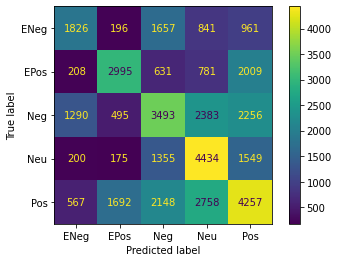

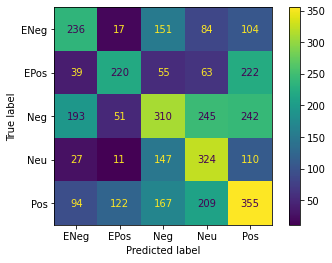

In [23]:
alpha = 1;
clf_MNB = MultinomialNB(alpha=alpha);
clf_MNB.fit(DT_train,train.Sentiment);
acc_train = clf_MNB.score(DT_train,train.Sentiment);

vectorizer2 = txt.CountVectorizer(vocabulary=vocabulary_list,min_df=min_pr);
DT_test = vectorizer2.fit_transform(test.OriginalTweet); 

acc_test = clf_MNB.score(DT_test,test.Sentiment);

y_train_pred = clf_MNB.predict(DT_train);
cm_train = confusion_matrix(train.Sentiment, y_train_pred, labels=train_sentiment_freq.index);
y_test_pred = clf_MNB.predict(DT_test);
cm_test = confusion_matrix(test.Sentiment, y_test_pred);

ConfusionMatrixDisplay(cm_train, display_labels=train_sentiment_freq.index).plot();
plt.show();

ConfusionMatrixDisplay(cm_test, display_labels=test_sentiment_freq.index).plot();
plt.show();

Jóval kisebb szótár vágási minimum értékkel (nagyobb méretű a szótár, a korábbi 211 helyett 10820!) készített szóvektorból tanítva a Bayes osztályozót, a konfúziós mátrixok alapján látható, hogy az osztályozó pontosabb, de még így is 9-10% körüli a hibás osztályba sorolás.

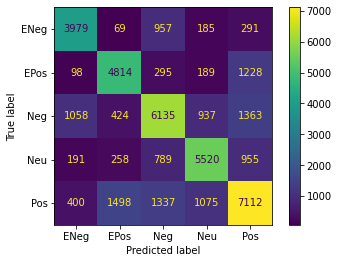

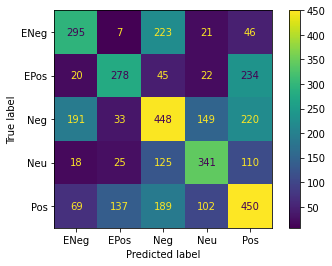

A szóvektor szótár hossza: 10820


In [25]:
min_pr = 0.0001;  
vectorizer = txt.CountVectorizer(stop_words='english',min_df=min_pr); 

DT_train = vectorizer.fit_transform(train.OriginalTweet); 
vocabulary_list = vectorizer.get_feature_names_out();
vocabulary = np.asarray(vocabulary_list);
stopwords = vectorizer.stop_words_;
keywords_freq = np.transpose(np.asarray(np.sum(DT_train,axis=0)))[:,0];

alpha = 1;
clf_MNB = MultinomialNB(alpha=alpha);
clf_MNB.fit(DT_train,train.Sentiment);
acc_train = clf_MNB.score(DT_train,train.Sentiment);

vectorizer2 = txt.CountVectorizer(vocabulary=vocabulary_list,min_df=min_pr);
DT_test = vectorizer2.fit_transform(test.OriginalTweet); 

acc_test = clf_MNB.score(DT_test,test.Sentiment);

y_train_pred = clf_MNB.predict(DT_train);
cm_train = confusion_matrix(train.Sentiment, y_train_pred, labels=train_sentiment_freq.index);
y_test_pred = clf_MNB.predict(DT_test);
cm_test = confusion_matrix(test.Sentiment, y_test_pred);

ConfusionMatrixDisplay(cm_train, display_labels=train_sentiment_freq.index).plot();
plt.show();

ConfusionMatrixDisplay(cm_test, display_labels=test_sentiment_freq.index).plot();
plt.show();

print(f"A szóvektor szótár hossza: {len(vocabulary)}")

Egy 5 klaszteres K-Means osztályozó kerül betanításra, de a kontingenciamátrix és a Davies-Bouldin pontok alapján nagyon nem megfelelő ezen adathalmazra.

In [26]:
kmeans = KMeans(n_clusters=5, random_state=2021)
kmeans.fit(DT_train)
centers = kmeans.cluster_centers_
clabels = kmeans.labels_

cm = contingency_matrix(train.Sentiment, clabels )
db_train = davies_bouldin_score(DT_train.toarray(), clabels )
db_test = davies_bouldin_score(DT_test.toarray(), kmeans.predict(DT_test) )

print(f"A Davies-Bouldin érkékek: tanító halmaz={db_train}, teszt halmaz={db_test}")

A Davies-Bouldin érkékek: tanító halmaz=5.378749043035394, teszt halmaz=5.289004652428398


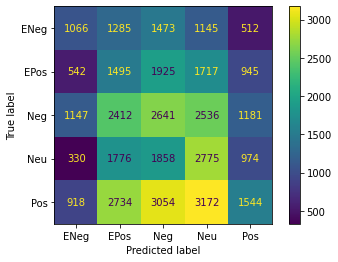

In [27]:
ConfusionMatrixDisplay(cm, display_labels=train_sentiment_freq.index).plot();
plt.show();
